In [13]:

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import cv2
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D # <--- This is important for 3d plotting 
import os
import cv2
import ntpath
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize

from sklearn import svm

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
from itertools import cycle


In [14]:
files=[] #store the filenames here
labels1=[] #store the labels here
dirname='dataset'
for dirname, _, filenames in os.walk(dirname):
    for filename in filenames:
        if filename.endswith('.png'):
            files.append(os.path.join(dirname, filename))            
            if filename.startswith('NL'):                
                labels1.append('NL')     #Normal retina      
                
            elif filename.startswith('ca'):  #Cataract              
                labels1.append('ca')
            elif filename.startswith('Gl'):  #Glaucoma              
                labels1.append('Gl')
            elif filename.startswith('Re'):  #Retina Disease              
                labels1.append('Re')
            


# Shuffle the data
combined = list(zip(files,labels1)) # combine the lists
np.random.shuffle(combined) # shuffle two lists together to keep order
files[:],labels1[:] = zip(*combined) #unzip the shuffled lists

In [15]:
def normalize_histograms(im): #normalizes the histogram of images
    im1=im.copy()
    for i in range(3):#loop throught the 3 colour channels
        imi=im[:,:,i]
        #print(imi.shape)
        minval=np.min(imi)
        maxval=np.max(imi)
        #print(minval,maxval)
        imrange=maxval-minval
        im1[:,:,i]=(255/(imrange+0.0001)*(imi-minval)) # imi-minval will turn the color range between 0-imrange, and the scaleing will stretch the range between 0-255
    return im1



def read_and_process_image(filename):
        im=cv2.imread(filename) #read image from file 
        # The following steps re needed for auto cropping the black paddings in the images
        
        gray = cv2.cvtColor(im,cv2.COLOR_BGR2GRAY) # convert 2 grayscale
        _,thresh = cv2.threshold(gray,10,255,cv2.THRESH_BINARY) # turn it into a binary image
        contours,hierarchy = cv2.findContours(thresh,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE) # find contours
        if len(contours) != 0:
            #find the biggest area
            cnt = max(contours, key = cv2.contourArea)
                      
            #find the bounding rect
            x,y,w,h = cv2.boundingRect(cnt)                  

            crop = im[y:y+h,x:x+w]# crop image
            #crop1=cv2.resize(crop,(im_size,im_size)) # resize to im_size X im_size size
            crop=normalize_histograms(crop)
            return crop
        else:
            return( normalize_histograms(im))



        
# histogram statistics (mean, standard deviations, energy, entropy, log-kurtosis)
#this code analyzes the probability of each pixel occurring and replaces zero value with a very small value
#mean helps identify if a pixel is too bright or dark
#standar deviation helps identify how spread the pixel values are and can help identify blurry regions
#The energy is a measure of how much of the image is in focus. A cataract can cause some parts of the image to be 
#out of focus,
#which would lower the energy.
#The entropy is a measure of how much information is in the image. If the image is very blurry or low contrast, there will be less information in the image and the entropy will be lower.
# the kurtosis is a measure of how "peaked" the histogram is. A high kurtosis can indicate that there are some 
#areas of the image that are particularly bright or dark, which could be a sign of cataracts.
def histogram_statistics(hist):
    #hist= cv2.calcHist([gr],[0],None,[256],[0,256])
    hist=hist/np.sum(hist)#probabilities
    hist=hist.reshape(-1)
    hist[hist==0]=10**-20 # replace zeros with a small number
    mn=np.sum([i*hist[i] for i in range(len(hist))]) # mean
    std_dev=np.sqrt(np.sum([((i-mn)**2)*hist[i] for i in range(len(hist))])) # standard deviation
    energy=np.sum([hist[i]**2 for i in range(len(hist))]) #energy
    entropy=np.sum([hist[i]*np.log(hist[i]) for i in range(len(hist))]) #entropy
    kurtosis=np.log(np.sum([(std_dev**-4)*((i-mn)**-4)*hist[i] for i in range(len(hist))])) # kurtosis
    return[mn,std_dev,energy,entropy,kurtosis]

# First, it resizes the image to a specified size and converts it to grayscale.
# It then applies an adaptive Gaussian thresholding technique to the image to create a
# binary image where the object of interest (cataract) appears white and the background appears black.
# The binary image is inverted so that the cataract becomes black and the background becomes white.
# The code then identifies contours in the binary image that represent the boundaries of the cataract.
# It calculates the area of each contour and excludes any contours that are too big (which usually represent 
# the image outline rather than the cataract).
# It then calculates the quartiles of the remaining contour areas.
# Finally, it returns the quartiles of the contour areas, the number of contours found, and the proportion 
# of white pixels in the thresholded image.
def thresholding_based_features(im,imsize,quartiles):
    im=cv2.resize(im,(imsize,imsize))
    gray=cv2.cvtColor(im,cv2.COLOR_BGR2GRAY)
    w=11 #window
    t=5#threshold
    counts=[]
    th = cv2.adaptiveThreshold(gray,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY,w,t) # adaptive gaussian threshold the image
    th=cv2.bitwise_not(th)    #invert the image (the black pixels will turn white and the white pixels will turn black)
    contours,hierarchy = cv2.findContours(th,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE) #find cntours in the image
    #print(len(contours))
    
    q=np.zeros(len(quartiles)) # quartiles of contours will be stored here
    

    for cnt in contours:
        area=cv2.contourArea(cnt) # calculate the area of the contours
        if area<40000: #Exclude contours that are too big, generally these are the image outlines
            counts.append(area) 
    if len(counts)>1:
        q=np.quantile(np.array(counts),quartiles) # contour quartiles
    
    return (q,len(counts),np.sum(th)/(255*th.shape[0]*th.shape[1]))# return the contour quartiles, number of contours, proportion of white pixels in the thresholded images
    #counts.append(np.sum(th)/(normalizing_factor*(th.shape[0]*th.shape[1])))

# The code then loops through all the image files and extracts the different features for each image, storing them
# in the above-mentioned lists.
# Finally, the code creates a feature vector for each image by combining all the different features extracted. 
# The X variable stores all the feature vectors.    
# color averages
B=[] 
G=[]
R=[]

#mini 16 bin histograms
hist_B=[]
hist_G=[]
hist_R=[]

#statistics fom full 256 bin shitogram
hist_feat_B=[]
hist_feat_G=[]
hist_feat_R=[]
hist_feat_GS=[]

#thresholding based features
mean_pixels=[] #proportion of white pixels
contour_quartiles=[] # contour area quartiles
no_of_contours=[] #total number of contours


quartiles=np.arange(0.1,1,0.1) # contour area quartiles
bins=16 # mini histogram bins

for f in files:
    im=read_and_process_image(f)
   
    
    #median color
    B.append(np.median(im[:,:,0]))
    G.append(np.median(im[:,:,1]))
    R.append(np.median(im[:,:,2]))
    
    #histograms
    hist_B.append(cv2.calcHist([im],[0],None,[bins],[0,256])/(im.size/3))
    hist_G.append(cv2.calcHist([im],[1],None,[bins],[0,256])/(im.size/3))
    hist_R.append(cv2.calcHist([im],[2],None,[bins],[0,256])/(im.size/3))
    
    
    #more histogram features
    
    hist_feat_B.append(histogram_statistics(cv2.calcHist([im],[0],None,[256],[0,256])))
    hist_feat_G.append(histogram_statistics(cv2.calcHist([im],[1],None,[256],[0,256])))
    hist_feat_R.append(histogram_statistics(cv2.calcHist([im],[2],None,[256],[0,256])))
    
    gr=cv2.cvtColor(im,cv2.COLOR_BGR2GRAY)
    gr=cv2.equalizeHist(gr)
    hist_feat_GS.append(histogram_statistics(cv2.calcHist([gr],[0],None,[256],[0,256])))
    
    #threshold featues
    q,nc,m=thresholding_based_features(im,256,quartiles)
    mean_pixels.append(m)
    contour_quartiles.append(q)
    no_of_contours.append(nc)

#create feature vectors
width_of_features=3*bins+len(quartiles)+2+20 #20 features are histogram statistics

X=np.zeros((len(files),width_of_features)) # this is where all features will be stored

for i in range(len(files)):
    X[i,0:bins]=hist_B[i].reshape(-1)
    X[i,bins:2*bins]=hist_G[i].reshape(-1)
    X[i,2*bins:3*bins]=hist_R[i].reshape(-1)
    X[i,3*bins:3*bins+len(quartiles)]=contour_quartiles[i].reshape(-1)
    X[i,3*bins+len(quartiles)]=mean_pixels[i]
    X[i,3*bins+len(quartiles)+1]=no_of_contours[i]
    start=3*bins+len(quartiles)+2
    X[i,start:start+5]=hist_feat_B[i]
    X[i,start+5:start+10]=hist_feat_G[i]
    X[i,start+10:start+15]=hist_feat_R[i]
    X[i,start+15:start+20]=hist_feat_B[i]

    


#train test divide (70:30)
index=int(len(labels1)*0.7)

X_train=X[:index,:]#this contains the features for the training data
Y_train1=labels1[:index]#this contain the labels for the training data

X_test=X[index:,:]#this contain the labels for the testing data
Y_test1=labels1[index:]#this contain the labels for the testing data

DT ca:
Accuracy: 0.8784530386740331
              precision    recall  f1-score   support

         ALL       0.92      0.94      0.93       154
          ca       0.60      0.56      0.58        27

    accuracy                           0.88       181
   macro avg       0.76      0.75      0.75       181
weighted avg       0.87      0.88      0.88       181

Confusion Matrix - DT:
[[144  10]
 [ 12  15]]


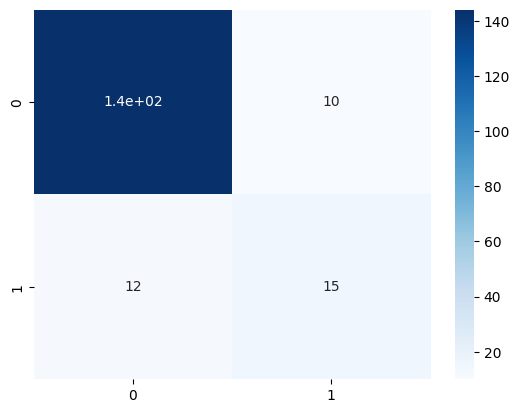

LR ca:
Accuracy: 0.8839779005524862
              precision    recall  f1-score   support

         ALL       0.90      0.97      0.93       154
          ca       0.71      0.37      0.49        27

    accuracy                           0.88       181
   macro avg       0.81      0.67      0.71       181
weighted avg       0.87      0.88      0.87       181

Confusion Matrix - LR:
[[150   4]
 [ 17  10]]


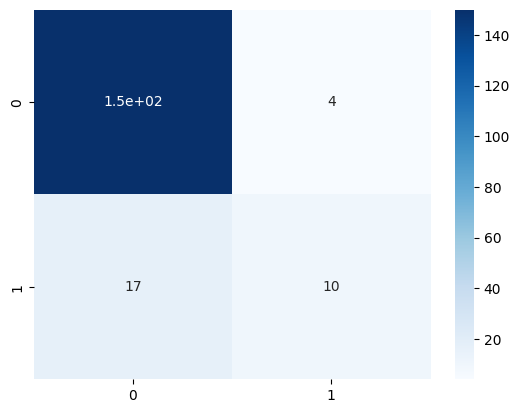

SVM ca:
Accuracy: 0.8397790055248618
              precision    recall  f1-score   support

         ALL       0.86      0.97      0.91       154
          ca       0.38      0.11      0.17        27

    accuracy                           0.84       181
   macro avg       0.62      0.54      0.54       181
weighted avg       0.79      0.84      0.80       181

Confusion Matrix - SVM:
[[149   5]
 [ 24   3]]


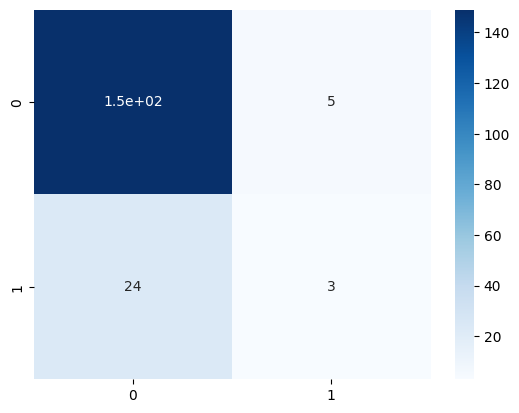

..................


In [16]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import svm
import seaborn as sns
import matplotlib.pyplot as plt

# List of diseases
diseases = np.unique(labels1)

d = 'ca'

if d in diseases:

        # Relabel training and test data for binary classification
        #The labels for the training and testing data are relabeled for binary classification by converting the label corresponding to the current disease (d) to d, and all other labels to 'ALL'. because this is a binary classification
        Y_train2 = np.where(np.array(Y_train1) == d, d, 'ALL')
        Y_test2 = np.where(np.array(Y_test1) == d, d, 'ALL')

        # Train decision tree model
        dt = DecisionTreeClassifier(random_state=42)
        dt.fit(X_train, Y_train2)

        # Make predictions on test set
        Y_testp = dt.predict(X_test)
        Y_trainp = dt.predict(X_train)

        # Calculate precision and f1 score for decision tree
        dt_report = classification_report(Y_test2, Y_testp)

        # Calculate accuracy
        test_accuracy = np.sum(np.array(Y_test2) == Y_testp) / len(Y_testp)
        print('DT '+d+':')
        print('Accuracy:', test_accuracy)
        print(dt_report)

        # Plot confusion matrix for decision tree
        dt_cm = confusion_matrix(Y_test2, Y_testp)
        print('Confusion Matrix - DT:')
        print(dt_cm)
        sns.heatmap(dt_cm, annot=True, cmap='Blues')
        plt.show()

        # Logistic regression
        lr = LogisticRegression( solver='saga', max_iter=5000, random_state=42)
        lr.fit(X_train, Y_train2)
        Y_testp = lr.predict(X_test)
        Y_trainp = lr.predict(X_train)

        # Calculate accuracy, precision, and F1 score for logistic regression
        test_accuracy = np.sum(np.array(Y_test2) == Y_testp) / len(Y_testp)
        lr_report = classification_report(Y_test2, Y_testp,zero_division=1)

        print('LR '+d+':')
        print('Accuracy:', test_accuracy)
        print(lr_report)

        # Plot confusion matrix for logistic regression
        lr_cm = confusion_matrix(Y_test2, Y_testp)
        print('Confusion Matrix - LR:')
        print(lr_cm)
        sns.heatmap(lr_cm, annot=True, cmap='Blues')
        plt.show()

        # SVM algorithm
        svm1 = svm.SVC(gamma='scale', probability=True)
        svm1.fit(X_train, Y_train2)
        Y_testp_svm = svm1.predict(X_test)

        # Calculate accuracy, precision, and F1 score for SVM
        test_accuracy_svm = np.sum(np.array(Y_test2) == Y_testp_svm) / len(Y_testp_svm)
        svm_report = classification_report(Y_test2, Y_testp_svm,zero_division=1)

        print('SVM '+d+':')
        print('Accuracy:', test_accuracy_svm)
        print(svm_report)

        # Plot confusion matrix for SVM
        svm_cm = confusion_matrix(Y_test2, Y_testp_svm)
        print('Confusion Matrix - SVM:')
        print(svm_cm)
        sns.heatmap(svm_cm, annot=True, cmap='Blues')
        plt.show()

        print('..................')


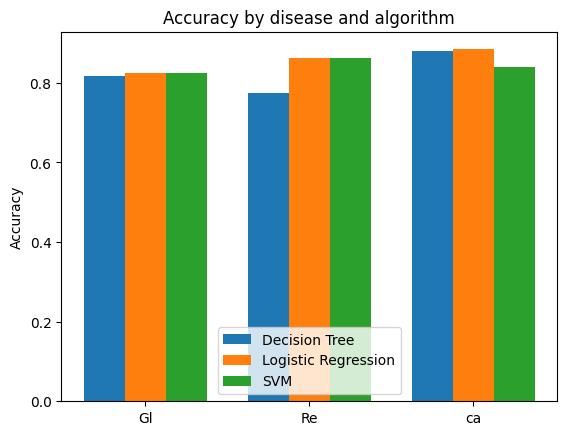

In [18]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.tree import DecisionTreeClassifier
diseases=np.unique(labels1)

# Create empty dictionaries to store accuracy for each algorithm
dt_accuracy = {}
lr_accuracy = {}
svm_accuracy = {}

# Loop over diseases
for d in diseases:
    if d != 'NL': # not for normal
        
        # Perform classification for each algorithm
        Y_train2 = np.where(np.array(Y_train1)==d, d, 'ALL') # relabel training data
        Y_test2 = np.where(np.array(Y_test1)==d, d, 'ALL')   # relabel test data
        
        dt = DecisionTreeClassifier(random_state=42)
        dt.fit(X_train, Y_train2)
        Y_testp_dt = dt.predict(X_test)
        test_accuracy_dt = np.sum(np.array(Y_test2) == Y_testp_dt) / len(Y_testp_dt)
        dt_accuracy[d] = test_accuracy_dt
        
        lr = LogisticRegression( solver='saga', max_iter=5000, random_state=42)
        lr.fit(X_train,Y_train2)
        Y_testp_lr = lr.predict(X_test)
        test_accuracy_lr = np.sum(np.array(Y_test2) == Y_testp_lr) / len(Y_testp_lr)
        lr_accuracy[d] = test_accuracy_lr

        svm1 = svm.SVC(gamma='scale',probability=True)
        svm1.fit(X_train, Y_train2)
        Y_testp_svm = svm1.predict(X_test)
        test_accuracy_svm = np.sum(np.array(Y_test2) == Y_testp_svm) / len(Y_testp_svm)
        svm_accuracy[d] = test_accuracy_svm

# Plot the bar chart
fig, ax = plt.subplots()
x = np.arange(len(diseases) - 1)
width = 0.25

rects1 = ax.bar(x - width, list(dt_accuracy.values()), width, label='Decision Tree')
rects2 = ax.bar(x, list(lr_accuracy.values()), width, label='Logistic Regression')
rects3 = ax.bar(x + width, list(svm_accuracy.values()), width, label='SVM')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Accuracy')
ax.set_title('Accuracy by disease and algorithm')
ax.set_xticks(x)
ax.set_xticklabels([d for d in diseases if d != 'NL'])
ax.legend()
plt.show()
